# Exportatory code to compare CT processing pipelines
    1. Pipelines: ANTS, FreeSurfer, CIVET
    2. Atlas: DKT

In [86]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Paths

In [2]:
data_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/'

ants_file = 'ABIDE_ants_thickness_data.csv'
fs53_file = 'ABIDE_fs5.3_thickness.csv'
fs51_file = 'cortical_fs5.1_measuresenigma_thickavg.csv'  
subject_chk_file = 'subject_check.csv'
pheno_file = 'ABIDE_Phenotype.csv'

# Read data

In [3]:
ants_data = pd.read_csv(data_dir + ants_file, header=2)
fs53_data = pd.read_csv(data_dir + fs53_file)
fs51_data = pd.read_csv(data_dir + fs51_file)
subject_ckh = pd.read_csv(data_dir + subject_chk_file)
pheno = pd.read_csv(data_dir + pheno_file)

In [4]:
subject_ckh.shape, pheno.shape, ants_data.shape, fs51_data.shape, fs53_data.shape

((1112, 7), (1112, 102), (1101, 99), (1112, 74), (976, 74))

# Create unified list of ROIs

In [5]:
# ANTS
ants_useful_cols = ['Structure Name']
ants_to_std_naming_dict = {}
ants_to_std_naming_dict['Structure Name'] = 'SubjID'
for roi in ants_data.columns:
    prefix = None
    name_split = roi.split(' ')
    if name_split[0] == 'left':
        prefix = 'L'
    if name_split[0] == 'right':
        prefix = 'R'

    if prefix is not None:
        ants_useful_cols.append(roi)
        std_name = prefix + '_' + ''.join(name_split[1:]) + '_thickavg'
        ants_to_std_naming_dict[roi] = std_name

In [6]:
# FS
fs_useful_cols = ['SubjID']
for roi in fs51_data.columns:
    prefix = None
    name_split = roi.split('_')
    if name_split[0] in ['L','R']:
        fs_useful_cols.append(roi)

In [7]:
# standardize common naming, subjects, and columns

ants_data_std = ants_data[ants_useful_cols]
ants_data_std = ants_data_std.rename(columns=ants_to_std_naming_dict)
print('ANTS data shape {}'.format(ants_data_std.shape))

fs51_data_std = fs51_data[fs_useful_cols]
fs53_data_std = fs53_data[fs_useful_cols]
print('FS 5.1 & 5.3 data shapes {}, {}'.format(fs51_data_std.shape, fs53_data_std.shape))

# Common columns 
common_cols = list(set(ants_data_std.columns) & set(fs51_data_std.columns))
common_roi_cols = common_cols.copy()
common_roi_cols.remove('SubjID')
ants_data_std = ants_data_std[common_cols]
ants_data_std['pipeline'] = np.tile('ants',len(ants_data_std))
fs51_data_std = fs51_data_std[common_cols]
fs51_data_std['pipeline'] = np.tile('fs51',len(fs51_data_std))
fs53_data_std = fs53_data_std[common_cols]
fs53_data_std['pipeline'] = np.tile('fs53',len(fs53_data_std))

# Common subjects
common_subs = list(set(ants_data_std['SubjID'].values) & set(fs51_data_std['SubjID'].values) & set(fs53_data_std['SubjID'].values))
ants_data_std = ants_data_std[ants_data_std['SubjID'].isin(common_subs)]
fs51_data_std = fs51_data_std[fs51_data_std['SubjID'].isin(common_subs)]
fs53_data_std = fs53_data_std[fs53_data_std['SubjID'].isin(common_subs)]

print('After selecting common subjects {} and columns {}\nData shapes for ants {}, FS 5.1 {}, FS 5.3 {}'.format(len(common_subs), 
                                                                                                                len(common_cols),
                                                                                                                ants_data_std.shape,
                                                                                                                fs51_data_std.shape,
                                                                                                                fs53_data_std.shape))



ANTS data shape (1101, 90)
FS 5.1 & 5.3 data shapes (1112, 69), (976, 69)
After selecting common subjects 975 and columns 63
Data shapes for ants (975, 64), FS 5.1 (975, 64), FS 5.3 (975, 64)


In [8]:
# Melt the longform df for plotting... 

master_data_df = ants_data_std.append(fs51_data_std).append(fs53_data_std)
master_data_df_melt = pd.melt(master_data_df, id_vars=['SubjID','pipeline'], value_vars=common_roi_cols,
                             var_name='ROI', value_name='thickness')
master_data_df_melt[['hemi','ROI','measure']] = master_data_df_melt['ROI'].str.split('_',expand=True)

# Plots: distributions

/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


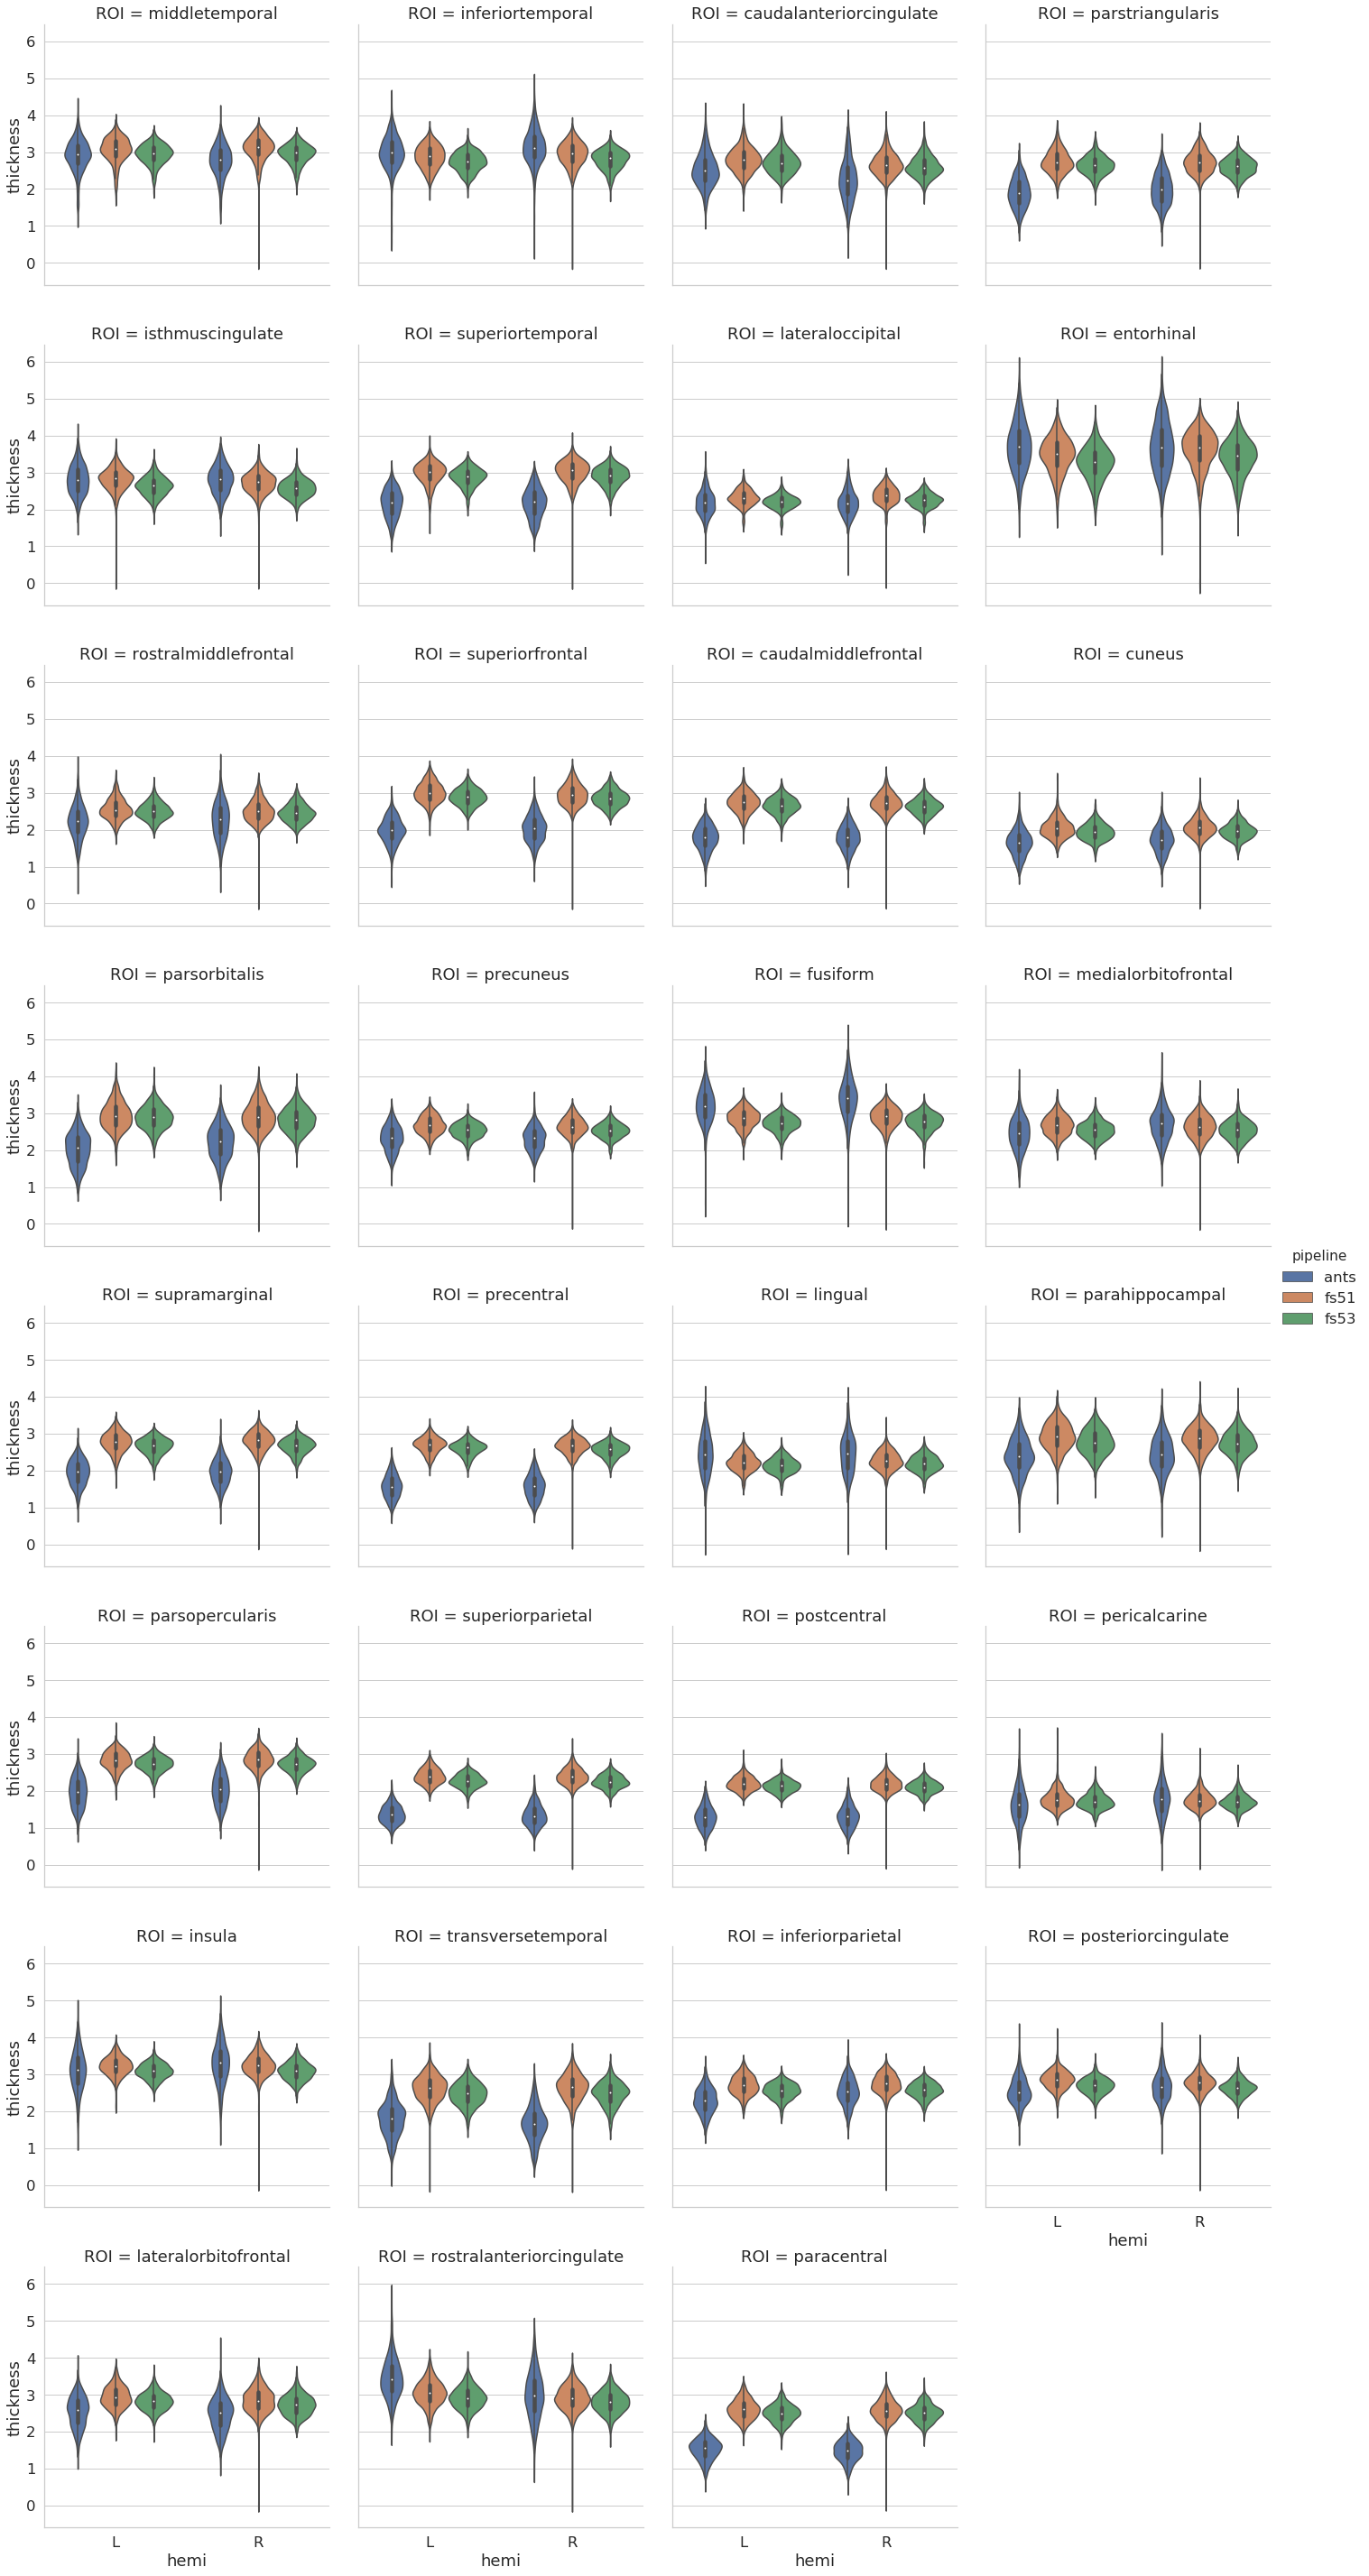

In [111]:
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='thickness', x='hemi', hue='pipeline', kind='violin', col='ROI', col_wrap=4, 
                    data=master_data_df_melt)


# Plots: correlations

avg corr:
ants-fs51 0.42738979489893975, ants-fs53 0.4743727435676521, fs51-fs53 0.8749944013636102


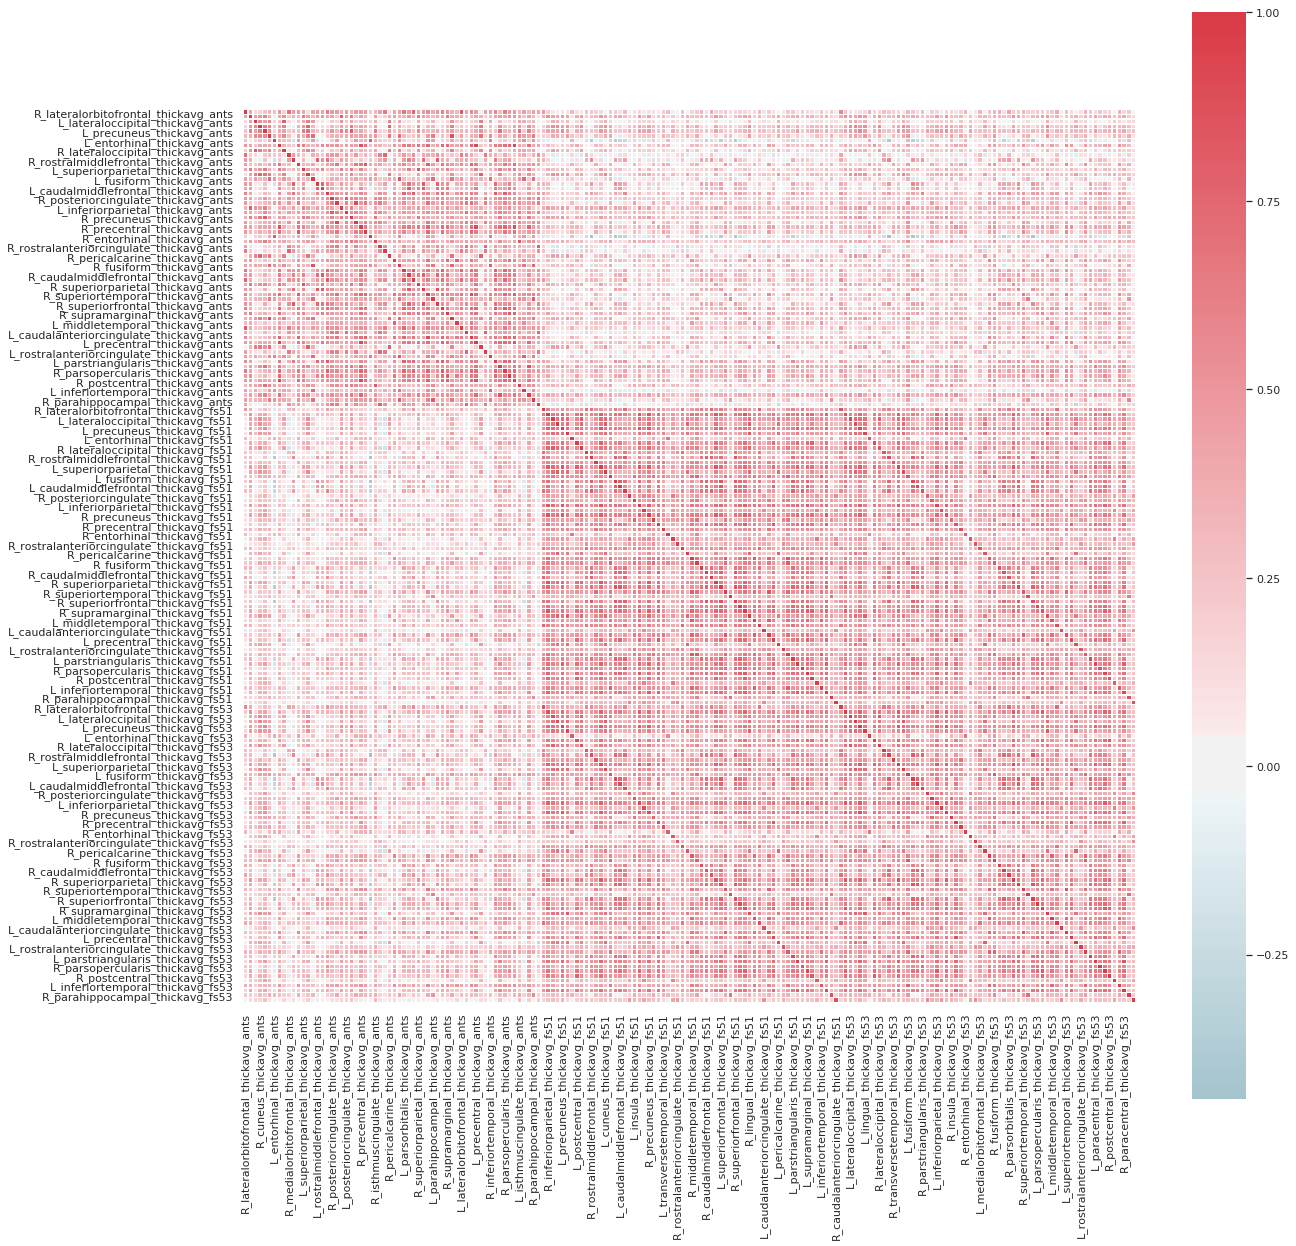

In [22]:

ants_data_corr = ants_data_std[common_cols]
ants_data_corr.columns = [str(col) + '_ants' for col in ants_data_corr.columns]
ants_data_corr = ants_data_corr.rename(columns={'SubjID_ants':'SubjID'})
fs51_data_corr = fs51_data_std[common_cols]
fs51_data_corr.columns = [str(col) + '_fs51' for col in fs51_data_corr.columns]
fs51_data_corr = fs51_data_corr.rename(columns={'SubjID_fs51':'SubjID'})
fs53_data_corr = fs53_data_std[common_cols]
fs53_data_corr.columns = [str(col) + '_fs53' for col in fs53_data_corr.columns]
fs53_data_corr = fs53_data_corr.rename(columns={'SubjID_fs53':'SubjID'})

concat_df = ants_data_corr.merge(fs51_data_corr, on='SubjID').merge(fs53_data_corr, on='SubjID')
corr = concat_df.corr()

# avg cross-correlations using diangonals (corrwith from pandas doesn't work)
ants_fs51 = corr.values[:62,62:124].diagonal()
ants_fs53 = corr.values[:62,124:].diagonal()
fs51_fs53 = corr.values[62:124,124:].diagonal()

print('avg corr:\nants-fs51 {}, ants-fs53 {}, fs51-fs53 {}'.format(np.mean(ants_fs51),
                                                                   np.mean(ants_fs53),
                                                                   np.mean(fs51_fs53)))

# plot all pair-wise corrs (not really needed for seeing inter-pipeline comparisons)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#cmap = sns.diverging_palette(220, 20, n=7)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(20,20))
sns.set(font_scale=1)
sns.heatmap(corr, cmap=cmap, square=True, linewidths=.5,center=0)


# Plots: clusters

Text(0.5, 0.98, 'fs5.3')

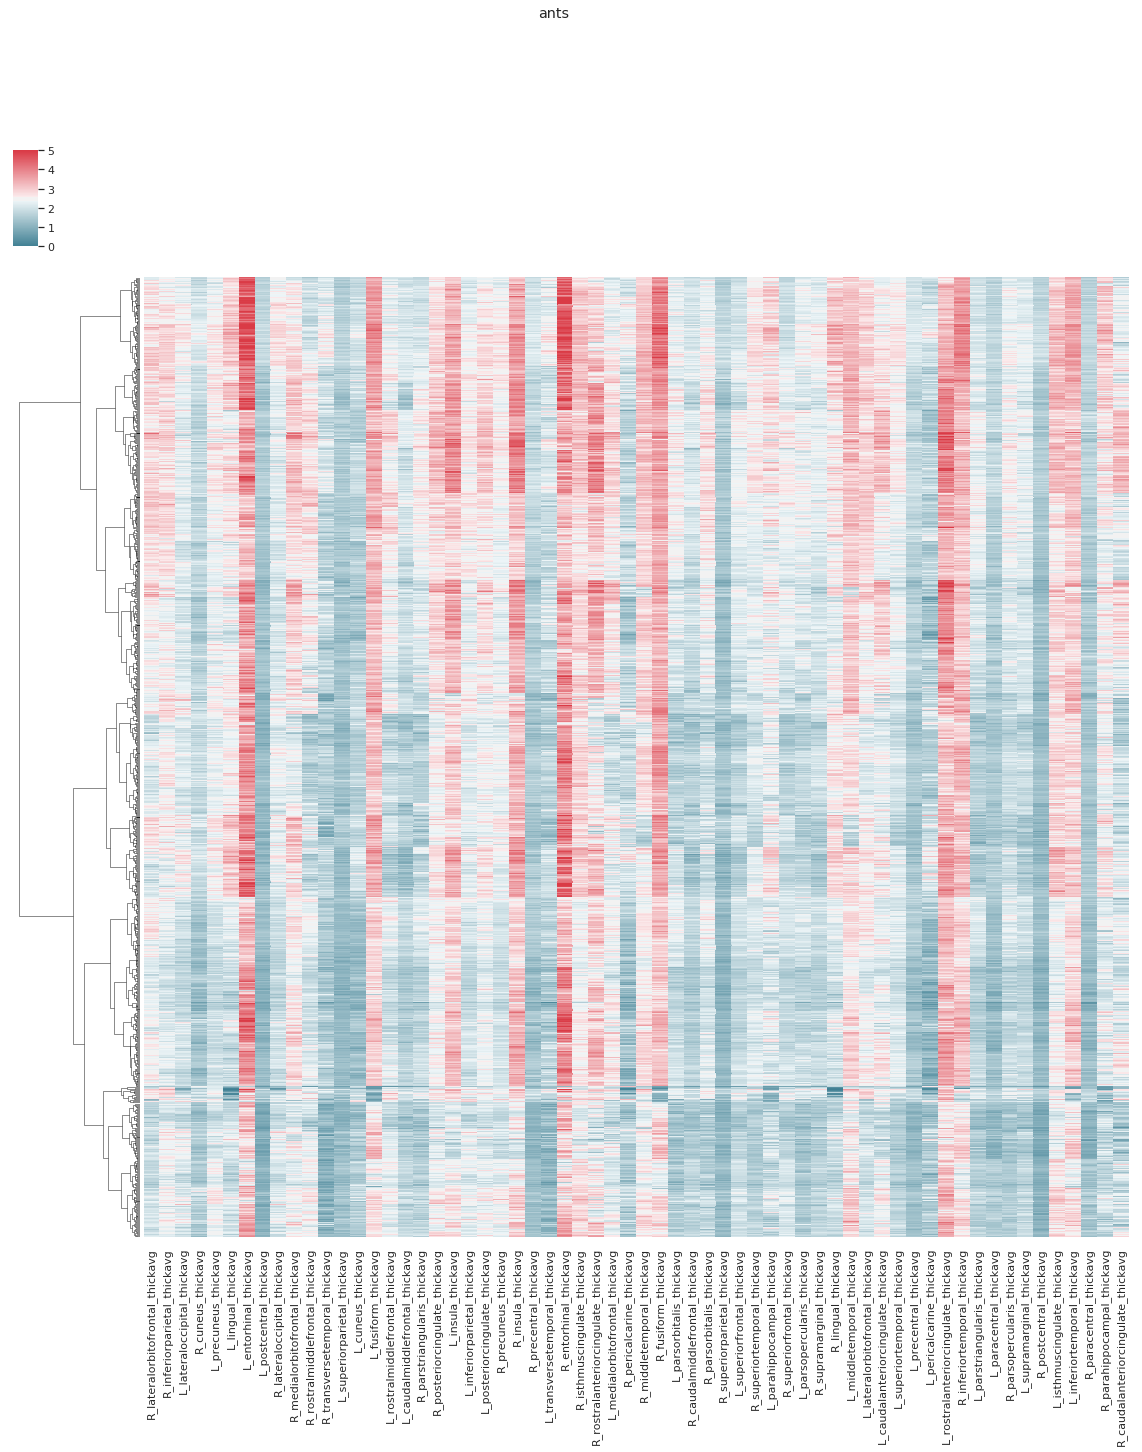

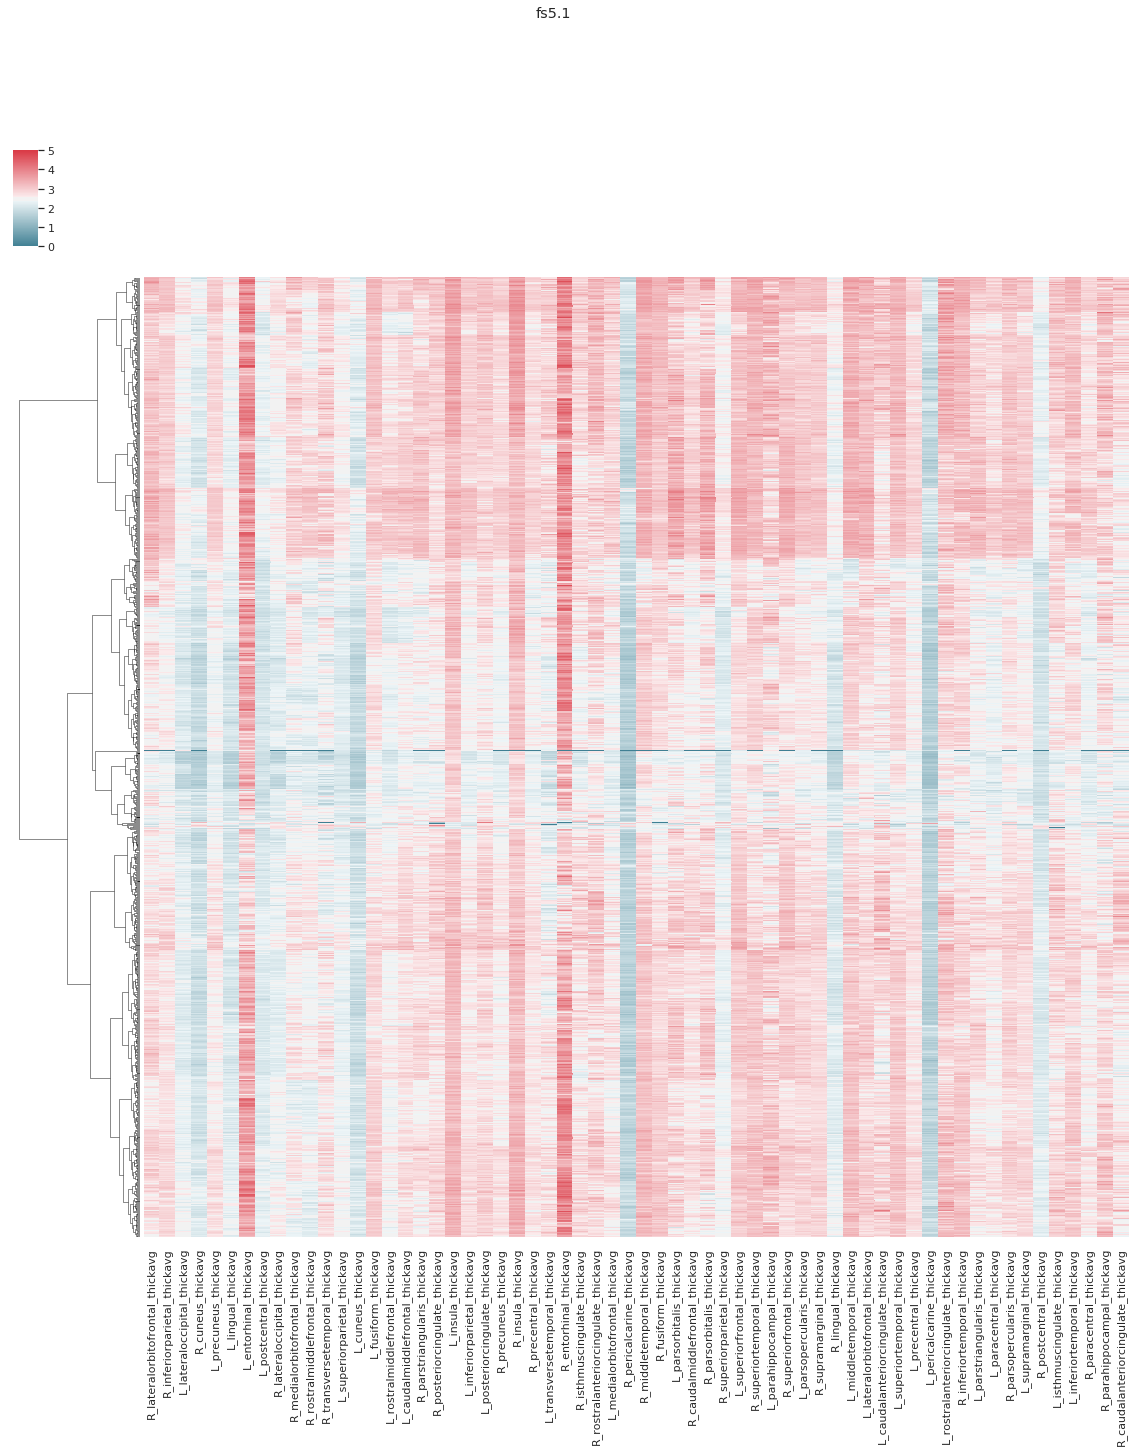

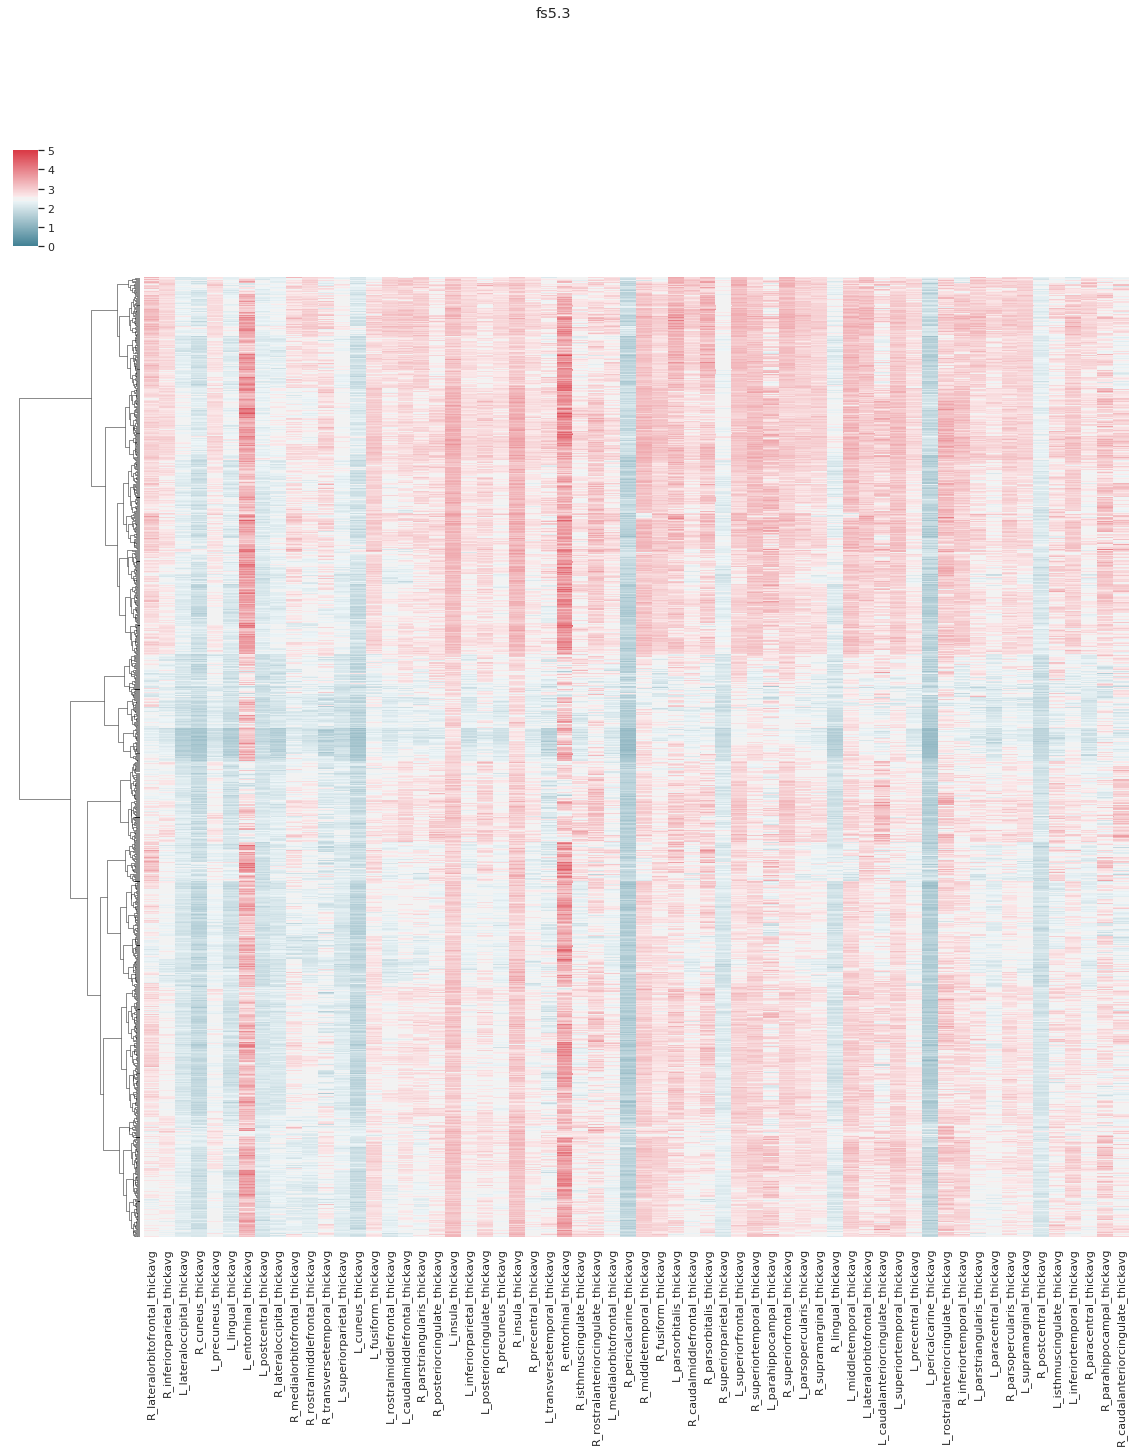

In [34]:
sns.set(style="white")
sns.set(font_scale=1)

similarity = 'euclidean'#'euclidean' #correlation
linkage = 'ward'

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

g1 = sns.clustermap(ants_data_std[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                   cmap=cmap, vmin=0, vmax=5, figsize=(20, 20),xticklabels=True, yticklabels=False)
g1.fig.suptitle('ants')

g2 = sns.clustermap(fs51_data_std[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                   cmap=cmap, vmin=0, vmax=5, figsize=(20, 20),xticklabels=True, yticklabels=False)
g2.fig.suptitle('fs5.1')

g3 = sns.clustermap(fs53_data_std[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                   cmap=cmap, vmin=0, vmax=5, figsize=(20, 20),xticklabels=True, yticklabels=False)
g3.fig.suptitle('fs5.3')

# Plot: t-SNE

In [54]:
from sklearn.manifold import TSNE
X = master_data_df[common_roi_cols].values
X_embedded = TSNE(n_components=2,init='pca').fit_transform(X)
X_embedded.shape

(2925, 2)

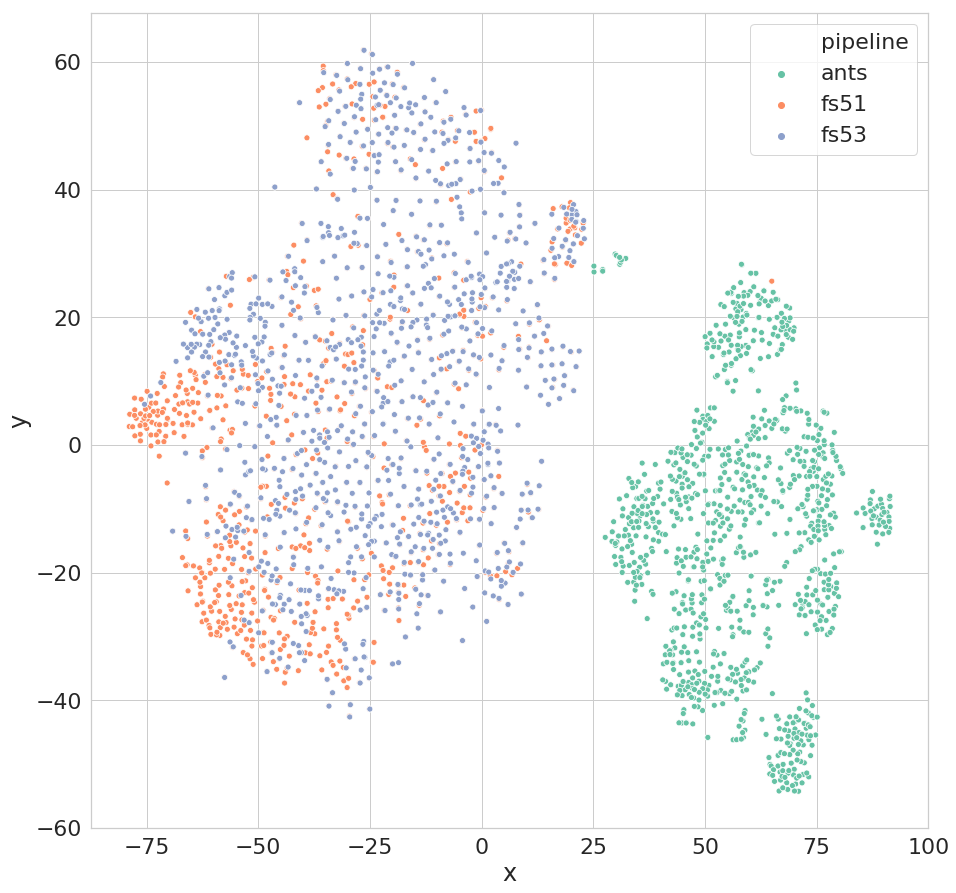

In [55]:
# plot
embed_df = pd.DataFrame(columns=['x','y'],data=X_embedded)
embed_df['pipeline'] = master_data_df['pipeline'].values

plt.figure(figsize=(15,15))
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    sns.scatterplot(x='x',y='y',hue='pipeline',data=embed_df,palette="Set2")

# ML classifier - sanity check

In [85]:
from sklearn.model_selection import cross_val_score
from sklearn import svm

pipe_pairs = {'ants vs. fs5.1' : ['ants','fs51'],
              'ants vs. fs5.3' : ['ants','fs53'],
              'fs5.1 vs. fs5.3' : ['fs51','fs53']}

n_folds = 10
scores = pd.DataFrame(columns=pipe_pairs.keys())
for i, pair in enumerate(pipe_pairs.keys()):
    ml_df = master_data_df[master_data_df['pipeline'].isin(pipe_pairs[pair])]
    X = ml_df[common_roi_cols].values
    y = pd.get_dummies(ml_df['pipeline']).values[:,0]

    clf = svm.SVC(kernel='linear', C=1)
    acc = cross_val_score(clf, X, y, cv=n_folds)
    scores[pair] = acc

    print('pipelines {}, discriminative acc mean:{:4.3f}, stdev:{:4.3f}'.format(pair,np.mean(acc),np.std(acc)))

pipelines ants vs. fs5.1, discriminative acc mean:0.999, stdev:0.002
pipelines ants vs. fs5.3, discriminative acc mean:1.000, stdev:0.000
pipelines fs5.1 vs. fs5.3, discriminative acc mean:0.741, stdev:0.056
